# OASIS toy experiments

In [39]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 
from jaxopt import LBFGS

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt

from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops, oasis, oasis_adaptive
from src.algorithm import conjugate_gradient as cg

plt.rcParams["figure.figsize"]=6,6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

#### Hutchinson's method

In [7]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

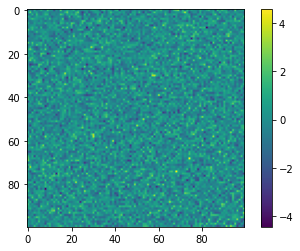

In [8]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [9]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [10]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [11]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [12]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

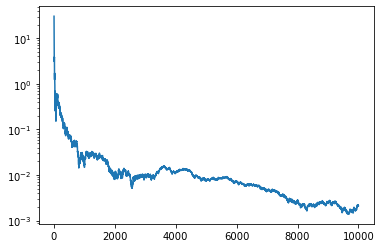

In [13]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [14]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [15]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [16]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [17]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

12.1 ms ± 987 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.89 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


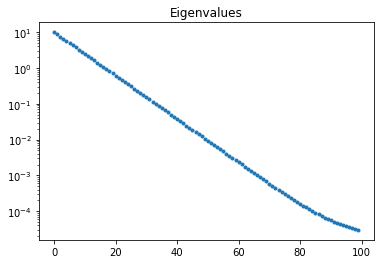

In [19]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-12)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [20]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 3.179388618281959
f(x_gt) = 1.188503047336687
gradF(x_gt) = [-0.06626366+9.92864861e-04j  0.03623302+3.52377460e-04j
 -0.02385434+1.42593565e-03j  0.04520644-5.31432902e-04j
  0.00123515+1.56733126e-03j  0.02199463+6.52825532e-04j
 -0.02137348-2.18105382e-03j -0.04590387-1.21446759e-03j
 -0.05022235+6.74217232e-04j  0.01385508+5.68469279e-04j
 -0.02782291+8.61377842e-04j -0.00474114-1.11694251e-04j
  0.03292228-6.28115596e-05j -0.00570525+1.75055856e-04j
  0.0242441 +7.02230265e-04j  0.02726129+1.67009318e-03j
  0.01146149-1.93671681e-03j  0.00351311-1.41173855e-04j
  0.01189251+2.56745556e-03j  0.01262402-1.14319672e-03j
  0.0189108 -1.74902096e-03j  0.00889022-1.22547056e-03j
 -0.01314989-1.05990385e-03j  0.04526126-1.67577569e-04j
 -0.02056401-5.79738580e-04j  0.00655781-3.38576391e-03j
  0.02825486-1.04874794e-03j -0.01248381-9.47406557e-04j
  0.05880585+1.11560657e-03j -0.01720289-1.06282777e-03j
 -0.00663612+8.70264206e-04j  0.00777885+1.04466721e-03j
  0.10898887+3

In [21]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [22]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 4.0310006834469245
Iter 400: loss = 3.481017415537121
Iter 600: loss = 3.1536220182927552
Iter 800: loss = 2.9411551096315818
Iter 1000: loss = 2.7916870136446064


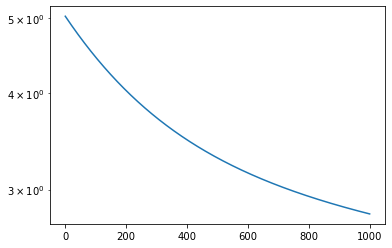

In [23]:
plt.semilogy(loss_gd)

In [24]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [25]:
#plt.plot(loss_n)

In [28]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

  cg iter 0 ||r|| = 0.9340375203812943
  cg iter 10 ||r|| = 0.06317574780155101
  cg iter 20 ||r|| = 0.004862027765070544
  cg iter 30 ||r|| = 0.0013854321287808818
  cg iter 40 ||r|| = 5.0024944446029644e-05
  cg iter 50 ||r|| = 3.729527944512494e-07
  cg iter 60 ||r|| = 6.580432236288745e-09
  cg iter 70 ||r|| = 8.887045150543011e-10
  cg iter 80 ||r|| = 8.385326073738297e-11
  cg iter 90 ||r|| = 1.1050109485635671e-11
  cg iter 100 ||r|| = 1.5923464390270822e-12
  cg iter 110 ||r|| = 2.381971932917285e-13
  cg iter 120 ||r|| = 1.2174702385886366e-13
  cg iter 130 ||r|| = 4.532336316574165e-14
  cg iter 140 ||r|| = 1.706254745543114e-14
  cg iter 150 ||r|| = 1.760311827973916e-14
  cg iter 160 ||r|| = 2.4432521244718805e-14
  cg iter 170 ||r|| = 4.1345368002727496e-15
  cg iter 180 ||r|| = 1.2675141739555895e-14
  cg iter 190 ||r|| = 1.2559625419705837e-14
  cg iter 200 ||r|| = 1.2373731091340935e-14
  cg iter 210 ||r|| = 1.1340535320024922e-14
  cg iter 220 ||r|| = 6.778585007666669

In [29]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

1.188503047336687
1.5629728375769154
2.7916870136446064


#### OASIS

In [30]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [31]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████| 100000/100000 [01:13<00:00, 1359.19it/s]


In [35]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [37]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 73.39it/s, eta=1.000e-01, loss=1.660e+00]

  Loss =  1.660e+00
  eta = 0.1


Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 111.16it/s, eta=1.000e-01, loss=1.622e+00]

  Loss =  1.622e+00
  eta = 0.1


Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 63.75it/s, eta=1.000e-01, loss=1.601e+00]

  Loss =  1.601e+00
  eta = 0.1


Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00, 98.19it/s, eta=1.000e-01, loss=1.588e+00]

  Loss =  1.588e+00
  eta = 0.1


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 180.32it/s, eta=1.000e-01, loss=1.579e+00]

  Loss =  1.579e+00
  eta = 0.1


Epoch 600/1000


100%|██████████| 1/1 [00:00<00:00, 97.40it/s, eta=1.000e-01, loss=1.574e+00]

  Loss =  1.574e+00
  eta = 0.1


Epoch 700/1000


100%|██████████| 1/1 [00:00<00:00, 102.30it/s, eta=1.000e-01, loss=1.570e+00]

  Loss =  1.570e+00
  eta = 0.1


Epoch 800/1000


100%|██████████| 1/1 [00:00<00:00, 58.54it/s, eta=1.000e-01, loss=1.568e+00]

  Loss =  1.568e+00
  eta = 0.1


Epoch 900/1000


100%|██████████| 1/1 [00:00<00:00, 133.89it/s, eta=1.000e-01, loss=1.566e+00]

  Loss =  1.566e+00
  eta = 0.1


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 101.37it/s, eta=1.000e-01, loss=1.565e+00]

  Loss =  1.565e+00
  eta = 0.1


In [40]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 50.34it/s, loss=1.566e+00]

  Loss =  1.566e+00


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 50.95it/s, loss=1.563e+00]

  Loss =  1.563e+00


0.9627742348829159
1.1597890047292487
0.9538497451478102
0.9619136885244608


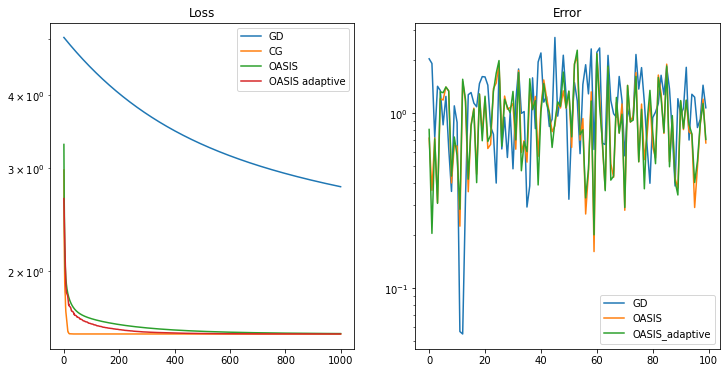

In [43]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [44]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [45]:
sig_noise = 10
lam = 0.1

In [46]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [47]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 3.80e+08


In [48]:
print(jnp.max(w))
print(jnp.min(w))

10000000068.134748
26.347926738318662


In [49]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [50]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

44.95416930523868
50.154404608892975
(100,)
(100,)
(100,)
(100,)


In [51]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [52]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(50.15440461, dtype=float64)

In [53]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

100%|██████████| 10000/10000 [00:38<00:00, 261.00it/s]


In [54]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os, _, _ = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:06<00:00,  7.49it/s, eta=1.000e-01, loss=1.297e+15]


  Loss =  1.206e+15
  eta = 0.1
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 89.86it/s, eta=1.000e-01, loss=2.612e+12]


  Loss =  3.694e+12
  eta = 0.1
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 113.40it/s, eta=1.000e-01, loss=1.239e+10]


  Loss =  1.684e+10
  eta = 0.1
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 88.64it/s, eta=1.000e-01, loss=7.616e+07] 


  Loss =  8.760e+07
  eta = 0.1
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 91.93it/s, eta=1.000e-01, loss=4.060e+05] 


  Loss =  5.114e+05
  eta = 0.1
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 94.60it/s, eta=1.000e-01, loss=1.157e+03] 


  Loss =  1.627e+03
  eta = 0.1
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 89.09it/s, eta=1.000e-01, loss=5.686e+01] 


  Loss =  5.733e+01
  eta = 0.1
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 91.06it/s, eta=1.000e-01, loss=4.902e+01] 


  Loss =  5.026e+01
  eta = 0.1
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 88.56it/s, eta=1.000e-01, loss=5.068e+01] 


  Loss =  5.019e+01
  eta = 0.1
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 85.84it/s, eta=1.000e-01, loss=4.973e+01] 


  Loss =  5.028e+01
  eta = 0.1
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 90.15it/s, eta=1.000e-01, loss=4.899e+01] 


  Loss =  5.026e+01
  eta = 0.1
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 87.09it/s, eta=1.000e-01, loss=5.053e+01] 


  Loss =  5.017e+01
  eta = 0.1
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 91.18it/s, eta=1.000e-01, loss=4.994e+01] 


  Loss =  5.019e+01
  eta = 0.1
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 88.79it/s, eta=1.000e-01, loss=4.896e+01] 


  Loss =  5.019e+01
  eta = 0.1
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 84.97it/s, eta=1.000e-01, loss=5.166e+01] 


  Loss =  5.059e+01
  eta = 0.1
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 85.07it/s, eta=1.000e-01, loss=5.039e+01]


  Loss =  5.020e+01
  eta = 0.1
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 89.44it/s, eta=1.000e-01, loss=4.985e+01] 


  Loss =  5.020e+01
  eta = 0.1
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 88.77it/s, eta=1.000e-01, loss=4.868e+01] 


  Loss =  5.027e+01
  eta = 0.1
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 104.98it/s, eta=1.000e-01, loss=5.132e+01]


  Loss =  5.021e+01
  eta = 0.1
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 123.01it/s, eta=1.000e-01, loss=4.819e+01]


  Loss =  5.023e+01
  eta = 0.1


In [55]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:02<00:00, 17.37it/s, loss=4.515e+15]


  Loss =  6.214e+15
Epoch 2/20


100%|██████████| 50/50 [00:02<00:00, 21.49it/s, loss=6.661e+13]


  Loss =  6.526e+13
Epoch 3/20


100%|██████████| 50/50 [00:02<00:00, 21.44it/s, loss=8.119e+11]


  Loss =  9.475e+11
Epoch 4/20


100%|██████████| 50/50 [00:02<00:00, 21.58it/s, loss=1.427e+10]


  Loss =  1.571e+10
Epoch 5/20


100%|██████████| 50/50 [00:02<00:00, 21.10it/s, loss=3.025e+08]


  Loss =  3.049e+08
Epoch 6/20


100%|██████████| 50/50 [00:02<00:00, 19.58it/s, loss=4.744e+06]


  Loss =  3.836e+06
Epoch 7/20


100%|██████████| 50/50 [00:02<00:00, 21.39it/s, loss=4.328e+04]


  Loss =  4.422e+04
Epoch 8/20


100%|██████████| 50/50 [00:02<00:00, 21.83it/s, loss=9.561e+02]


  Loss =  8.053e+02
Epoch 9/20


100%|██████████| 50/50 [00:02<00:00, 21.40it/s, loss=6.032e+01]


  Loss =  6.113e+01
Epoch 10/20


100%|██████████| 50/50 [00:02<00:00, 21.41it/s, loss=4.844e+01]


  Loss =  5.034e+01
Epoch 11/20


100%|██████████| 50/50 [00:02<00:00, 21.06it/s, loss=5.050e+01]


  Loss =  5.016e+01
Epoch 12/20


100%|██████████| 50/50 [00:02<00:00, 20.01it/s, loss=4.844e+01]


  Loss =  5.017e+01
Epoch 13/20


100%|██████████| 50/50 [00:02<00:00, 21.55it/s, loss=5.057e+01]


  Loss =  5.018e+01
Epoch 14/20


100%|██████████| 50/50 [00:02<00:00, 21.43it/s, loss=5.182e+01]


  Loss =  5.017e+01
Epoch 15/20


100%|██████████| 50/50 [00:02<00:00, 21.24it/s, loss=4.761e+01]


  Loss =  5.026e+01
Epoch 16/20


100%|██████████| 50/50 [00:02<00:00, 21.47it/s, loss=4.937e+01]


  Loss =  5.025e+01
Epoch 17/20


100%|██████████| 50/50 [00:02<00:00, 21.27it/s, loss=4.948e+01]


  Loss =  5.017e+01
Epoch 18/20


100%|██████████| 50/50 [00:02<00:00, 20.87it/s, loss=4.900e+01]


  Loss =  5.035e+01
Epoch 19/20


100%|██████████| 50/50 [00:01<00:00, 25.64it/s, loss=4.910e+01]


  Loss =  5.015e+01
Epoch 20/20


100%|██████████| 50/50 [00:02<00:00, 21.20it/s, loss=4.811e+01]


  Loss =  5.024e+01


In [56]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/20


100%|██████████| 1/1 [00:03<00:00,  3.83s/it, eta=1.000e-01, loss=1.433e+18]


  Loss =  1.433e+18
  eta = 0.1
Epoch 2/20


100%|██████████| 1/1 [00:00<00:00, 78.00it/s, eta=1.000e-01, loss=1.171e+18]


  Loss =  1.171e+18
  eta = 0.1
Epoch 3/20


100%|██████████| 1/1 [00:00<00:00, 74.05it/s, eta=1.000e-01, loss=9.720e+17]


  Loss =  9.720e+17
  eta = 0.1
Epoch 4/20


100%|██████████| 1/1 [00:00<00:00, 73.60it/s, eta=1.000e-01, loss=8.121e+17]


  Loss =  8.121e+17
  eta = 0.1
Epoch 5/20


100%|██████████| 1/1 [00:00<00:00, 76.67it/s, eta=1.000e-01, loss=6.810e+17]


  Loss =  6.810e+17
  eta = 0.1
Epoch 6/20


100%|██████████| 1/1 [00:00<00:00, 45.64it/s, eta=1.000e-01, loss=5.727e+17]


  Loss =  5.727e+17
  eta = 0.1
Epoch 7/20


100%|██████████| 1/1 [00:00<00:00, 72.70it/s, eta=1.000e-01, loss=4.826e+17]


  Loss =  4.826e+17
  eta = 0.1
Epoch 8/20


100%|██████████| 1/1 [00:00<00:00, 74.55it/s, eta=1.000e-01, loss=4.075e+17]


  Loss =  4.075e+17
  eta = 0.1
Epoch 9/20


100%|██████████| 1/1 [00:00<00:00, 11.98it/s, eta=1.000e-01, loss=3.448e+17]


  Loss =  3.448e+17
  eta = 0.1
Epoch 10/20


100%|██████████| 1/1 [00:00<00:00, 11.81it/s, eta=1.000e-01, loss=2.922e+17]


  Loss =  2.922e+17
  eta = 0.1
Epoch 11/20


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, eta=1.000e-01, loss=2.481e+17]


  Loss =  2.481e+17
  eta = 0.1
Epoch 12/20


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, eta=1.000e-01, loss=2.111e+17]


  Loss =  2.111e+17
  eta = 0.1
Epoch 13/20


100%|██████████| 1/1 [00:00<00:00, 11.77it/s, eta=1.000e-01, loss=1.798e+17]


  Loss =  1.798e+17
  eta = 0.1
Epoch 14/20


100%|██████████| 1/1 [00:00<00:00, 11.95it/s, eta=1.000e-01, loss=1.535e+17]


  Loss =  1.535e+17
  eta = 0.1
Epoch 15/20


100%|██████████| 1/1 [00:00<00:00, 62.74it/s, eta=1.000e-01, loss=1.312e+17]


  Loss =  1.312e+17
  eta = 0.1
Epoch 16/20


100%|██████████| 1/1 [00:00<00:00, 57.59it/s, eta=1.000e-01, loss=1.123e+17]


  Loss =  1.123e+17
  eta = 0.1
Epoch 17/20


100%|██████████| 1/1 [00:00<00:00, 58.48it/s, eta=1.000e-01, loss=9.623e+16]


  Loss =  9.623e+16
  eta = 0.1
Epoch 18/20


100%|██████████| 1/1 [00:00<00:00, 59.03it/s, eta=1.000e-01, loss=8.260e+16]


  Loss =  8.260e+16
  eta = 0.1
Epoch 19/20


100%|██████████| 1/1 [00:00<00:00, 65.31it/s, eta=1.000e-01, loss=7.098e+16]


  Loss =  7.098e+16
  eta = 0.1
Epoch 20/20


100%|██████████| 1/1 [00:00<00:00, 53.18it/s, eta=1.000e-01, loss=6.108e+16]

  Loss =  6.108e+16
  eta = 0.1


In [57]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/20


100%|██████████| 1/1 [00:00<00:00, 13.09it/s, loss=1.288e+18]


  Loss =  1.288e+18
Epoch 2/20


100%|██████████| 1/1 [00:00<00:00, 11.18it/s, loss=1.167e+18]


  Loss =  1.167e+18
Epoch 3/20


100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=1.012e+18]


  Loss =  1.012e+18
Epoch 4/20


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, loss=8.080e+17]


  Loss =  8.080e+17
Epoch 5/20


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, loss=5.589e+17]


  Loss =  5.589e+17
Epoch 6/20


100%|██████████| 1/1 [00:00<00:00, 13.69it/s, loss=3.013e+17]


  Loss =  3.013e+17
Epoch 7/20


100%|██████████| 1/1 [00:00<00:00, 13.63it/s, loss=1.108e+17]


  Loss =  1.108e+17
Epoch 8/20


100%|██████████| 1/1 [00:00<00:00,  3.88it/s, loss=1.199e+17]


  Loss =  1.199e+17
Epoch 9/20


100%|██████████| 1/1 [00:00<00:00, 11.35it/s, loss=5.142e+16]


  Loss =  5.142e+16
Epoch 10/20


100%|██████████| 1/1 [00:00<00:00, 12.00it/s, loss=4.825e+16]


  Loss =  4.825e+16
Epoch 11/20


100%|██████████| 1/1 [00:00<00:00, 13.14it/s, loss=4.520e+16]


  Loss =  4.520e+16
Epoch 12/20


100%|██████████| 1/1 [00:00<00:00, 13.79it/s, loss=4.118e+16]


  Loss =  4.118e+16
Epoch 13/20


100%|██████████| 1/1 [00:00<00:00,  4.17it/s, loss=3.557e+16]


  Loss =  3.557e+16
Epoch 14/20


100%|██████████| 1/1 [00:00<00:00, 10.55it/s, loss=2.799e+16]


  Loss =  2.799e+16
Epoch 15/20


100%|██████████| 1/1 [00:00<00:00, 11.83it/s, loss=1.885e+16]


  Loss =  1.885e+16
Epoch 16/20


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, loss=9.674e+15]


  Loss =  9.674e+15
Epoch 17/20


100%|██████████| 1/1 [00:00<00:00, 14.29it/s, loss=3.304e+15]


  Loss =  3.304e+15
Epoch 18/20


100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=6.488e+15]


  Loss =  6.488e+15
Epoch 19/20


100%|██████████| 1/1 [00:00<00:00,  2.87it/s, loss=2.507e+15]


  Loss =  2.507e+15
Epoch 20/20


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, loss=1.895e+15]

  Loss =  1.895e+15


In [60]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _, _, _= sgd(key, gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

mask is None
Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 396.04it/s, alpha=1.000e-18, grad=4.399e+16, loss=2.924e+17]


  |Grad| = 6.445e+16
  Loss = 3.066e+17
  alpha = 1e-18
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 494.37it/s, alpha=1.000e-18, grad=1.868e+16, loss=6.614e+16]


  |Grad| = 2.726e+16
  Loss = 6.684e+16
  alpha = 1e-18
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 186.66it/s, alpha=1.000e-18, grad=6.131e+15, loss=1.494e+16]


  |Grad| = 1.299e+16
  Loss = 1.631e+16
  alpha = 1e-18
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 481.04it/s, alpha=1.000e-18, grad=5.860e+15, loss=4.826e+15]


  |Grad| = 6.416e+15
  Loss = 4.294e+15
  alpha = 1e-18
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 458.67it/s, alpha=1.000e-18, grad=2.026e+15, loss=1.220e+15]


  |Grad| = 3.304e+15
  Loss = 1.188e+15
  alpha = 1e-18
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 458.43it/s, alpha=1.000e-18, grad=1.282e+15, loss=3.027e+14]

  |Grad| = 1.688e+15
  Loss = 3.390e+14
  alpha = 1e-18
Epoch 7/20 


100%|██████████| 50/50 [00:00<00:00, 443.56it/s, alpha=1.000e-18, grad=7.479e+14, loss=1.124e+14]


  |Grad| = 9.520e+14
  Loss = 1.005e+14
  alpha = 1e-18
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 76.69it/s, alpha=1.000e-18, grad=3.152e+14, loss=2.482e+13] 


  |Grad| = 5.275e+14
  Loss = 3.038e+13
  alpha = 1e-18
Epoch 9/20 

100%|██████████| 50/50 [00:00<00:00, 461.93it/s, alpha=1.000e-18, grad=2.140e+14, loss=1.046e+13]


  |Grad| = 2.952e+14
  Loss = 9.361e+12
  alpha = 1e-18
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 461.10it/s, alpha=1.000e-18, grad=1.033e+14, loss=2.915e+12]


  |Grad| = 1.588e+14
  Loss = 2.946e+12
  alpha = 1e-18
Epoch 11/20 

100%|██████████| 50/50 [00:00<00:00, 478.99it/s, alpha=1.000e-18, grad=6.961e+13, loss=9.714e+11]


  |Grad| = 9.138e+13
  Loss = 9.321e+11
  alpha = 1e-18
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 456.63it/s, alpha=1.000e-18, grad=3.157e+13, loss=2.694e+11]


  |Grad| = 4.901e+13
  Loss = 2.993e+11
  alpha = 1e-18
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 173.66it/s, alpha=1.000e-18, grad=1.996e+13, loss=9.796e+10]


  |Grad| = 2.849e+13
  Loss = 9.720e+10
  alpha = 1e-18
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 482.30it/s, alpha=1.000e-18, grad=1.921e+13, loss=3.109e+10]


  |Grad| = 1.685e+13
  Loss = 3.179e+10
  alpha = 1e-18
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 506.32it/s, alpha=1.000e-18, grad=6.637e+12, loss=9.588e+09]


  |Grad| = 9.305e+12
  Loss = 1.045e+10
  alpha = 1e-18
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 94.91it/s, alpha=1.000e-18, grad=3.689e+12, loss=3.492e+09] 


  |Grad| = 5.379e+12
  Loss = 3.467e+09
  alpha = 1e-18
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 444.00it/s, alpha=1.000e-18, grad=2.916e+12, loss=1.124e+09]


  |Grad| = 3.228e+12
  Loss = 1.157e+09
  alpha = 1e-18
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 327.67it/s, alpha=1.000e-18, grad=1.620e+12, loss=3.776e+08]


  |Grad| = 1.803e+12
  Loss = 3.880e+08
  alpha = 1e-18
Epoch 19/20 

100%|██████████| 50/50 [00:00<00:00, 465.74it/s, alpha=1.000e-18, grad=7.822e+11, loss=1.186e+08]

  |Grad| = 1.076e+12
  Loss = 1.302e+08
  alpha = 1e-18
Epoch 20/20 


100%|██████████| 50/50 [00:00<00:00, 477.37it/s, alpha=1.000e-18, grad=3.910e+11, loss=3.769e+07]


  |Grad| = 6.032e+11
  Loss = 4.392e+07
  alpha = 1e-18


In [63]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _, _, _ = sgd(key, gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

mask is None
Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 398.52it/s, alpha=1.000e-01, grad=1.996e+15, loss=7.164e+14]

  |Grad| = 2.759e+16
  Loss = 9.179e+14
  alpha = 0.1
Epoch 2/20 


100%|██████████| 50/50 [00:00<00:00, 165.41it/s, alpha=1.000e-01, grad=1.044e+14, loss=1.675e+12]


  |Grad| = 7.430e+14
  Loss = 1.821e+12
  alpha = 0.1
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 495.26it/s, alpha=1.000e-01, grad=5.798e+12, loss=4.662e+09]


  |Grad| = 3.704e+13
  Loss = 5.273e+09
  alpha = 0.1
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 505.96it/s, alpha=1.000e-01, grad=3.226e+11, loss=1.368e+07]


  |Grad| = 2.043e+12
  Loss = 1.742e+07
  alpha = 0.1
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 232.20it/s, alpha=1.000e-01, grad=2.323e+10, loss=5.176e+04]


  |Grad| = 1.226e+11
  Loss = 5.907e+04
  alpha = 0.1
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 472.78it/s, alpha=1.000e-01, grad=1.001e+09, loss=2.153e+02]


  |Grad| = 6.650e+09
  Loss = 2.680e+02
  alpha = 0.1
Epoch 7/20 

100%|██████████| 50/50 [00:00<00:00, 135.67it/s, alpha=1.000e-01, grad=9.851e+07, loss=5.242e+01]


  |Grad| = 4.421e+08
  Loss = 5.102e+01
  alpha = 0.1
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 422.63it/s, alpha=1.000e-01, grad=8.218e+07, loss=5.029e+01]

  |Grad| = 9.088e+07
  Loss = 5.026e+01
  alpha = 0.1
Epoch 9/20 


100%|██████████| 50/50 [00:00<00:00, 469.24it/s, alpha=1.000e-01, grad=7.924e+07, loss=4.925e+01]


  |Grad| = 9.100e+07
  Loss = 5.026e+01
  alpha = 0.1
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 188.49it/s, alpha=1.000e-01, grad=8.306e+07, loss=5.041e+01]


  |Grad| = 8.477e+07
  Loss = 5.022e+01
  alpha = 0.1
Epoch 11/20 

100%|██████████| 50/50 [00:00<00:00, 475.93it/s, alpha=1.000e-01, grad=7.661e+07, loss=4.978e+01]


  |Grad| = 8.117e+07
  Loss = 5.020e+01
  alpha = 0.1
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 179.87it/s, alpha=1.000e-01, grad=7.416e+07, loss=4.930e+01]


  |Grad| = 8.471e+07
  Loss = 5.019e+01
  alpha = 0.1
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 477.90it/s, alpha=1.000e-01, grad=7.913e+07, loss=4.803e+01]


  |Grad| = 8.815e+07
  Loss = 5.020e+01
  alpha = 0.1
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 480.96it/s, alpha=1.000e-01, grad=7.273e+07, loss=4.949e+01]


  |Grad| = 8.708e+07
  Loss = 5.024e+01
  alpha = 0.1
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 75.99it/s, alpha=1.000e-01, grad=1.090e+08, loss=5.123e+01]


  |Grad| = 8.046e+07
  Loss = 5.034e+01
  alpha = 0.1
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 466.18it/s, alpha=1.000e-01, grad=1.007e+08, loss=5.022e+01]


  |Grad| = 8.604e+07
  Loss = 5.027e+01
  alpha = 0.1
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 470.42it/s, alpha=1.000e-01, grad=7.520e+07, loss=5.002e+01]


  |Grad| = 8.845e+07
  Loss = 5.029e+01
  alpha = 0.1
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 451.30it/s, alpha=1.000e-01, grad=9.732e+07, loss=4.812e+01]

  |Grad| = 8.621e+07
  Loss = 5.023e+01
  alpha = 0.1
Epoch 19/20 


100%|██████████| 50/50 [00:00<00:00, 463.92it/s, alpha=1.000e-01, grad=7.153e+07, loss=4.953e+01]


  |Grad| = 8.440e+07
  Loss = 5.020e+01
  alpha = 0.1
Epoch 20/20 

100%|██████████| 50/50 [00:00<00:00, 177.91it/s, alpha=1.000e-01, grad=1.096e+08, loss=4.987e+01]


  |Grad| = 8.414e+07
  Loss = 5.041e+01
  alpha = 0.1


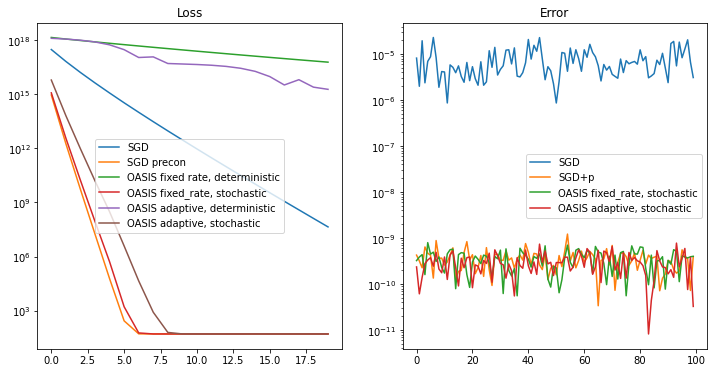

In [64]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

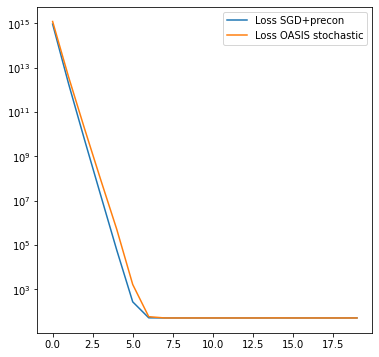

In [65]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [66]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


50.154404608892975
43919782.720642515
50.409851646444594
6.108148453233447e+16
50.23406948740421
1894930448642445.5
50.23921955148257
